In [27]:
# Standard Imports

import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Load MongoDB

from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
tab = db['songs']
collection = db.tab

# Authorize Spotify API

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [28]:
from bson.son import SON
pipeline = [
    {"$unwind": "$producer"},
    {"$group": {"_id": "$producer", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
]
import pprint
pprint.pprint(list(collection.aggregate(pipeline)))

[{'_id': 'Rick Rubin', 'count': 2039},
 {'_id': 'George Martin', 'count': 1420},
 {'_id': 'Brian Eno', 'count': 77},
 {'_id': 'Stock Aitken Waterman', 'count': 62},
 {'_id': 'Dr. Dre', 'count': 43}]


In [29]:
len(collection.find_one()['audio_analysis']['segments'])

498

### Gameplan: 

Make a `timbre` array for every song of size (12,100) by taking the first 100 segments. Make a dictionary where...

In [30]:
test_dict = {'colA':[1,2,3],
             'colB':[4,5,6],
             'colC':['now','we are','done'],
             'colD':[np.array([1,2,3]),np.array([1,2,3]),np.array([1,2,3])]}

pd.DataFrame(test_dict)['colD'][0]

array([1, 2, 3])

In [31]:
track = collection.find_one()['track']
artist = collection.find_one()['artist']
producer = collection.find_one()['producer']

In [32]:
timbre_list = []

for i in range(100):
    timbre_list.append(collection.find_one()['audio_analysis']['segments'][i]['timbre'])
    
timbre = np.stack(timbre_list)

In [33]:
timbre.flatten().shape

(1200,)

Let's see if we can use PCA to distinguish between George Martin (ct. 1420) and Rick Rubin (ct. 2039)

In [34]:
gm = collection.find({'producer':'George Martin'})
rr = collection.find({'producer':'Rick Rubin'})

In [24]:
for song in gm:
    print (song)

In [36]:
tracks = []
artists = []
producers = []
timbres = []
collections = [gm, rr]

for collection in collections:
    for song in collection:
        track = song['track']
        artist = song['artist']
        producer = song['producer']

        timbre_list=[]
        
        #songs must have at least 80 segments to be in the analysis
        if len((song['audio_analysis']['segments'])) >= 80:
            for i in range(80):
                try:
                    timbre_list.append(song['audio_analysis']['segments'][i]['timbre'])
                except:
                    continue
            timbre = np.concatenate(timbre_list, axis=0)

            tracks.append(track)
            artists.append(artist)
            producers.append(producer)
            timbres.append(timbre)
        
producer_dict = {}
producer_dict['track'] = tracks
producer_dict['artist'] = artists
producer_dict['producer'] = producers
producer_dict['timbre'] = timbres

producer_df = pd.DataFrame(producer_dict)

producer_df.head()

,track,artist,producer,timbre
0,12 Bar Original - Anthology 2 Version,the Beatles,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
1,Across the Universe,the Beatles,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
2,Act Naturally,Buck Owens and the Buckaroos,George Martin,"[41.561, 196.927, 110.997, 28.169, 47.868, -31..."
3,Alfie,Cilla Black,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."
4,All I've Got To Do - Remastered 2009,the Beatles,George Martin,"[0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ..."


In [37]:
producer_df.producer.value_counts()

Rick Rubin       2032
George Martin    1410
Name: producer, dtype: int64

In [38]:
producer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 4 columns):
track       3442 non-null object
artist      3442 non-null object
producer    3442 non-null object
timbre      3442 non-null object
dtypes: object(4)
memory usage: 107.6+ KB


In [39]:
# Class balance a df. 2032 Rick Rubin and 1410 George Martin

df = producer_df[producer_df['producer'] == "George Martin"]
df2 = producer_df[producer_df['producer'] == "Rick Rubin"].sample(1410, random_state = 137)

In [40]:
data = pd.concat([df, df2], axis = 0)
data['target'] = (data['producer'] == 'George Martin').astype(int)

In [41]:
data.head(), data.tail()

(                                   track                        artist  \
 0  12 Bar Original - Anthology 2 Version                   the Beatles   
 1                    Across the Universe                   the Beatles   
 2                          Act Naturally  Buck Owens and the Buckaroos   
 3                                  Alfie                   Cilla Black   
 4   All I've Got To Do - Remastered 2009                   the Beatles   
 
         producer                                             timbre  target  
 0  George Martin  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 1  George Martin  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 2  George Martin  [41.561, 196.927, 110.997, 28.169, 47.868, -31...       1  
 3  George Martin  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  
 4  George Martin  [0.0, 171.13, 9.469, -28.48, 57.491, -50.067, ...       1  ,
                              track                      artist    produc

In [42]:
data.producer.value_counts()

Rick Rubin       1410
George Martin    1410
Name: producer, dtype: int64

In [43]:
# Set up a test train split. 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [44]:
X = np.stack(data['timbre'].to_list())
y = data['target'].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 137, test_size = 0.3 )

In [46]:
X_train.shape, X_test.shape

((1974, 960), (846, 960))

In [47]:
ss = StandardScaler()
X_train_centered = ss.fit_transform(X_train)
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_train_centered)

In [48]:
def scree_plot(ax, pca, n_components_to_plot=8, title=None):
    """Make a scree plot showing the variance explained (i.e. varaince of the projections) for the principal components in a fit sklearn PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the skree plot.
      
    title: str
      A title for the skree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.2f}%".format(vals[i]), 
                   (ind[i]+0.2, vals[i]+0.005), 
                   va="bottom", 
                   ha="center", 
                   fontsize=12)

    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

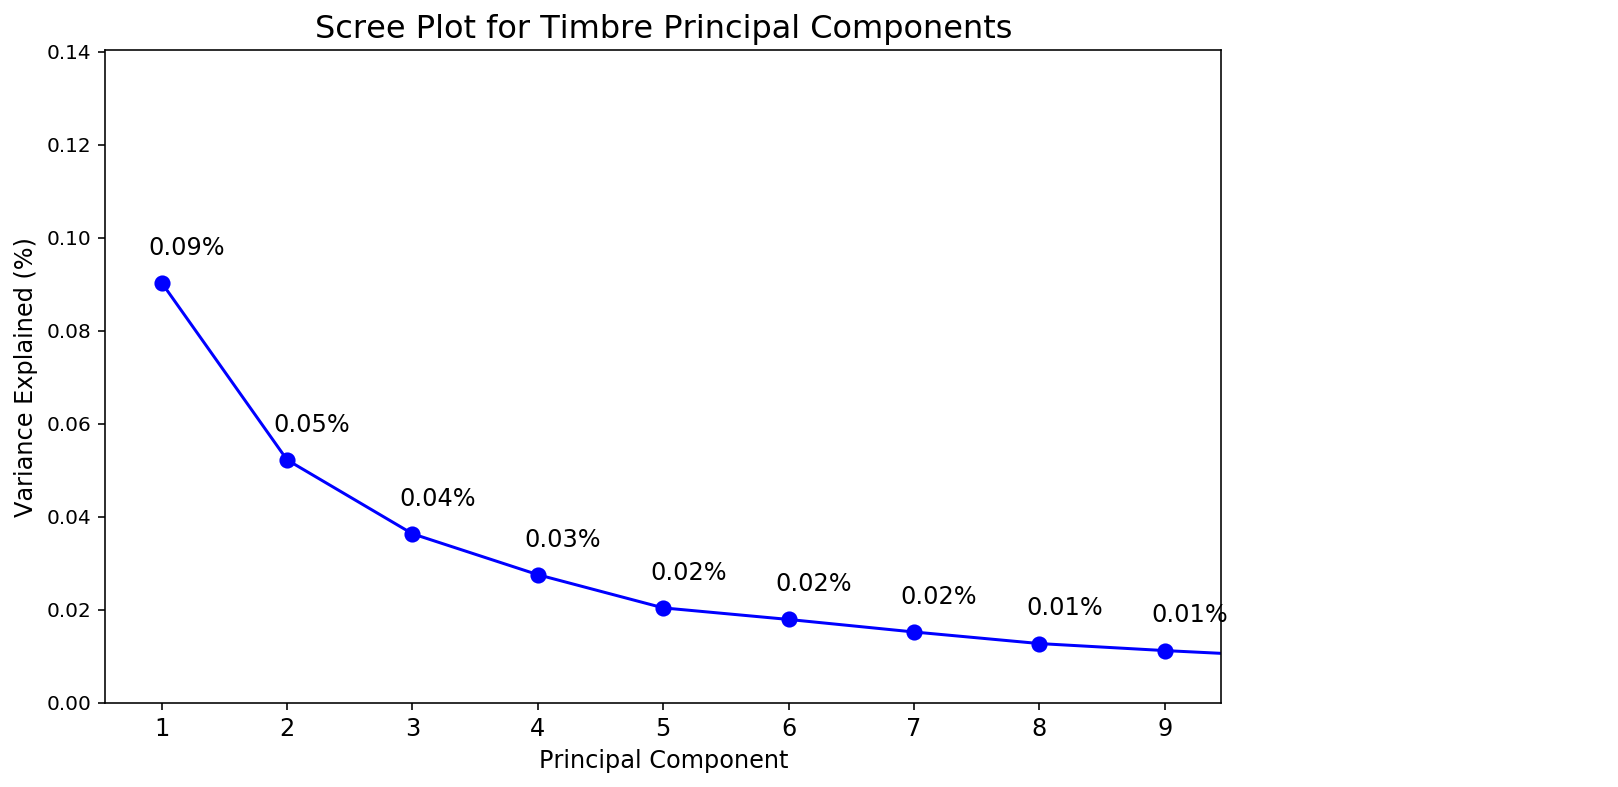

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
scree_plot(ax, pca, title="Scree Plot for Timbre Principal Components")

Looks like there's an elbow around **6 components**.

In [50]:
def plot_mnist_embedding(ax, X, y, title=None, alpha = 1):
    """Plot an embedding of the mnist dataset onto a plane.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    X: numpy.array, shape (n, 2)
      A two dimensional array containing the coordinates of the embedding.
      
    y: numpy.array
      The labels of the datapoints.  Should be digits.
      
    title: str
      A title for the plot.
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 str(y[i]), 
                 color=plt.cm.Set1((y[i]+1) / 10.), 
                 fontdict={'weight': 'bold', 'size': 12},
                 alpha = alpha)

    ax.set_xticks([]), 
    ax.set_yticks([])
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([-0.1,1.1])

    if title is not None:
        ax.set_title(title, fontsize=16)

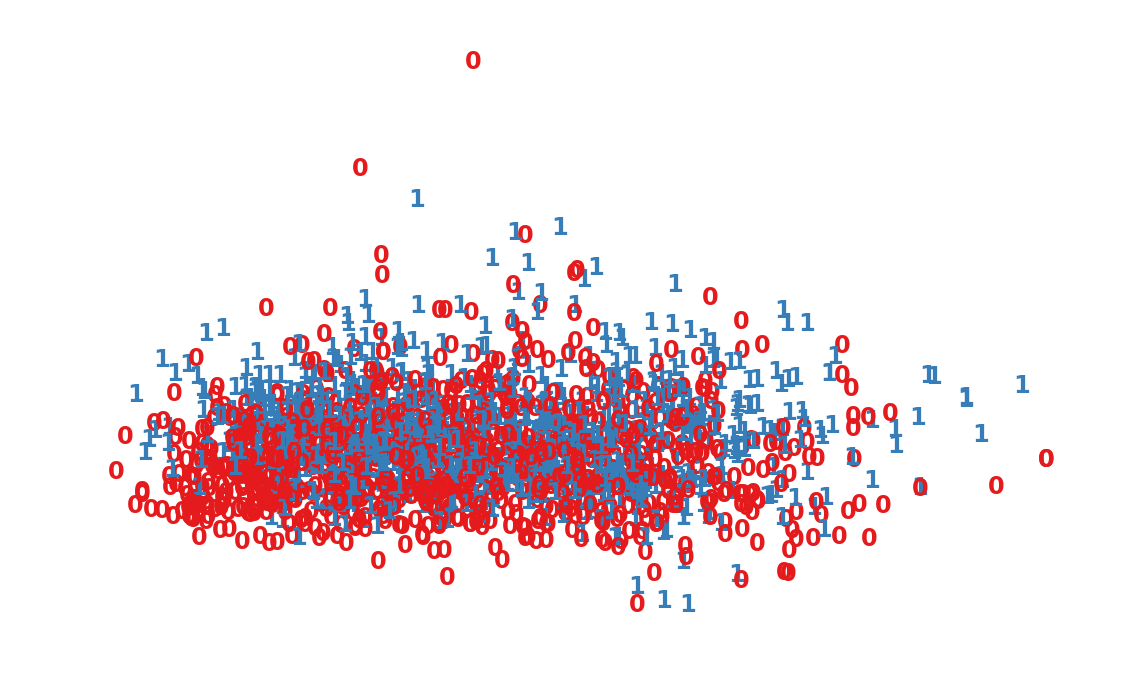

In [51]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_centered)


fig, ax = plt.subplots(figsize=(10, 6))
plot_mnist_embedding(ax, X_pca, y_train)

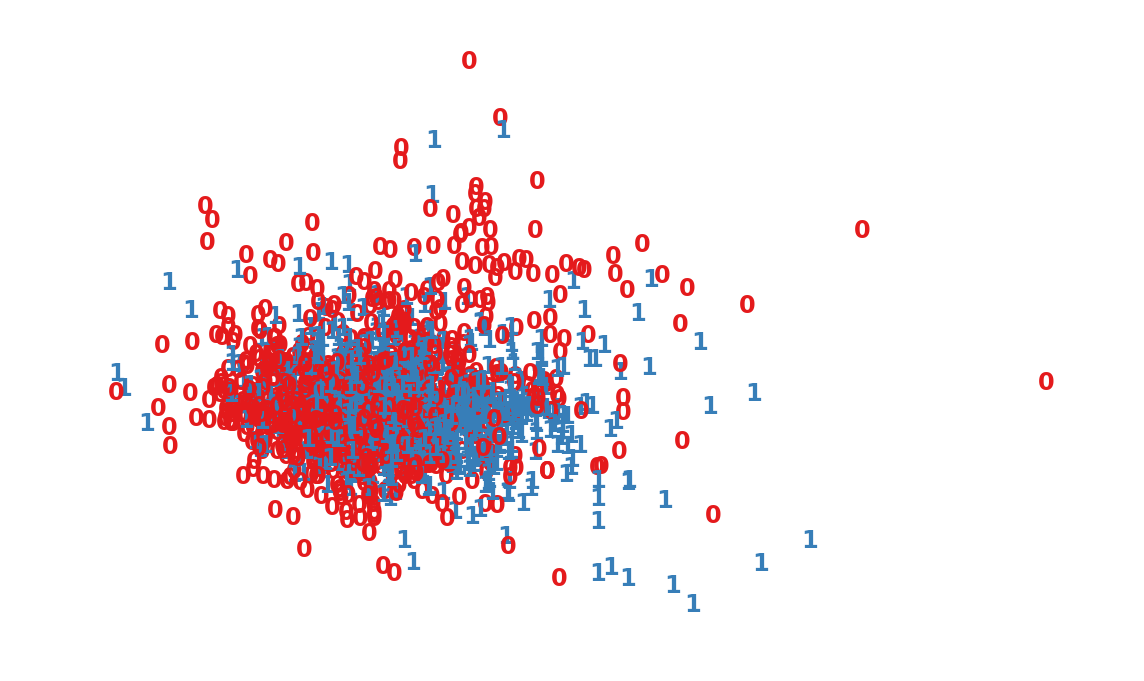

In [52]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_centered)
X_pca = X_pca[:,1:]


fig, ax = plt.subplots(figsize=(10, 6))
plot_mnist_embedding(ax, X_pca, y_train)

Maka a KNN Classifier

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
knn = KNeighborsClassifier()

In [55]:
X_test_centered = ss.transform(X_test)

In [56]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_train_centered)
X_test_pca = pca.transform(X_test_centered)


knn.fit(X_pca, y_train)
y_hat = knn.predict(X_test_pca)
acc = knn.score(X_test_pca, y_test)

print('Accuracy is: {}'.format(acc))

Accuracy is: 0.6300236406619385


/Users/Maxwell/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


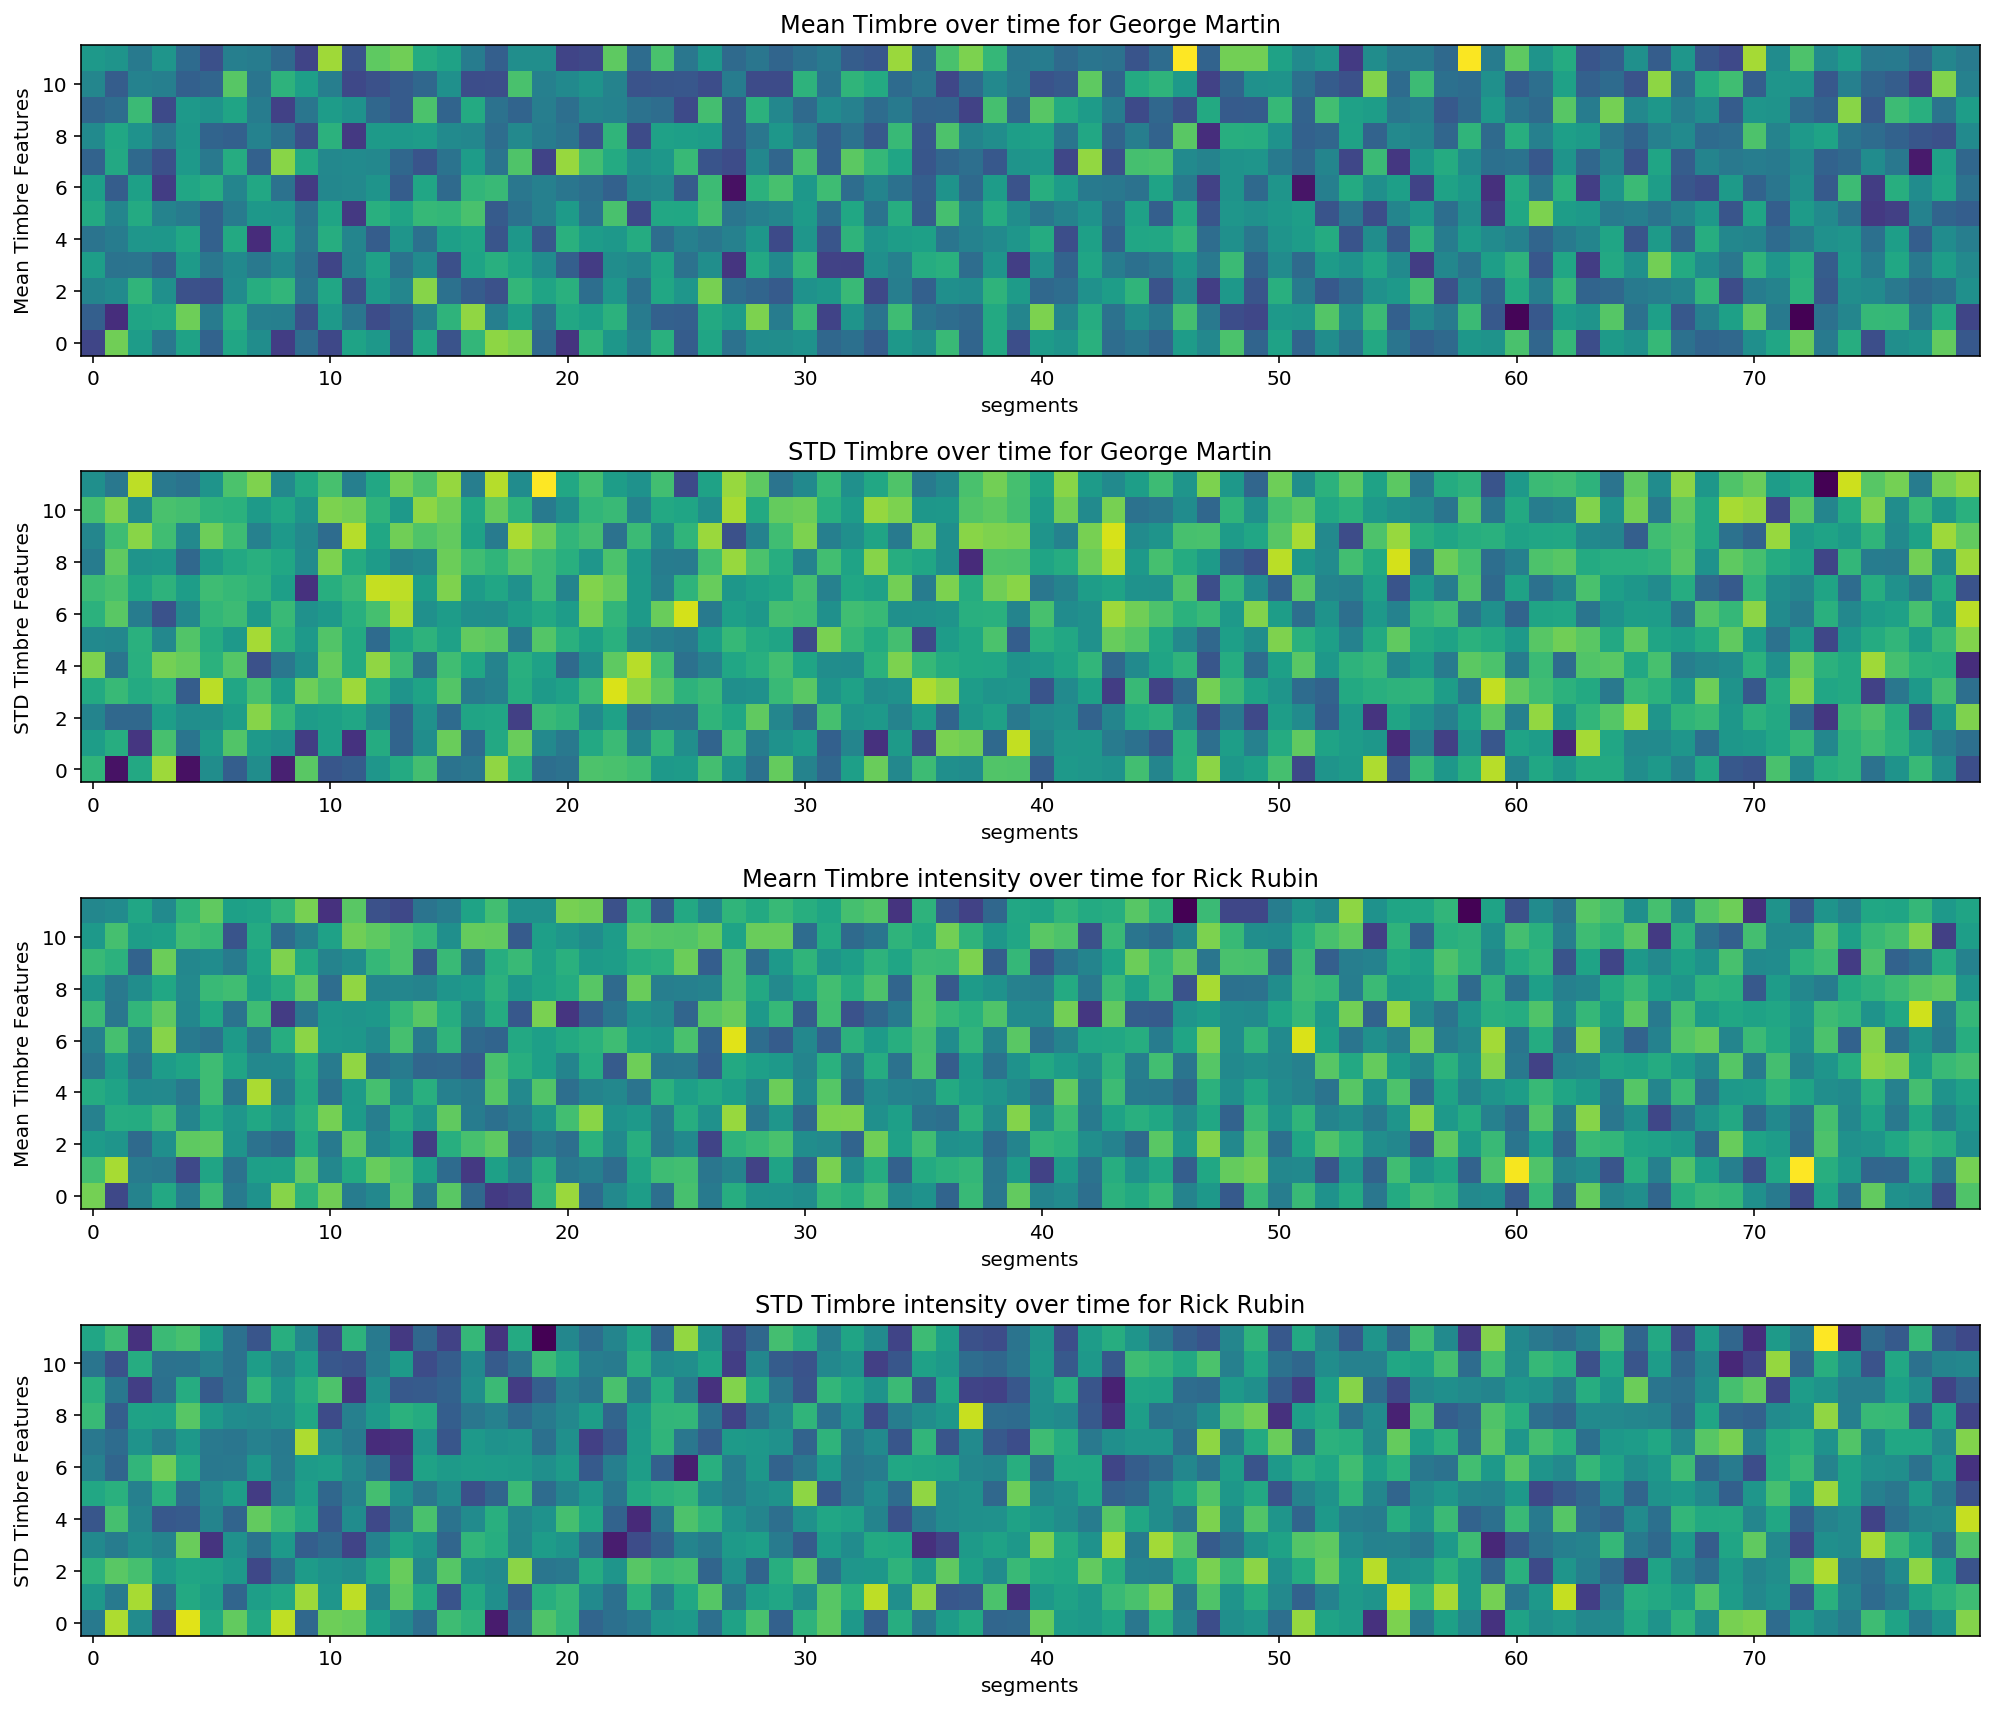

In [30]:
X_train_centered[y_train == 1].mean(axis = 0).reshape(12,-1)

fig, axs = plt.subplots(4, figsize=(14, 12))
axs[0].imshow(X_train_centered[y_train == 1].mean(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[0].set_xlabel('segments')
axs[0].set_ylabel('Mean Timbre Features')
# axs[0].colorbar()
axs[0].set_title("Mean Timbre over time for George Martin")

axs[1].imshow(X_train_centered[y_train == 1].std(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[1].set_xlabel('segments')
axs[1].set_ylabel('STD Timbre Features')
# axs[0].colorbar()
axs[1].set_title("STD Timbre over time for George Martin")

axs[2].imshow(X_train_centered[y_train == 0].mean(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[2].set_xlabel('segments')
axs[2].set_ylabel('Mean Timbre Features')
# axs[1].colorbar()
axs[2].set_title("Mearn Timbre intensity over time for Rick Rubin")

axs[3].imshow(X_train_centered[y_train == 0].std(axis = 0).reshape(12,-1), aspect='auto', origin = 'lower')
axs[3].set_xlabel('segments')
axs[3].set_ylabel('STD Timbre Features')
# axs[1].colorbar()
axs[3].set_title("STD Timbre intensity over time for Rick Rubin")

plt.tight_layout()
fig.show()

# What if every segment was its own data point?

In [57]:
data['timbre'][125].reshape(-1,12).shape

(80, 12)

If every segment is its own data point, and every song is 80 segments long, then our target needs to be multiplied by 80.

In [58]:
y_long = np.tile(data['target'].values.reshape(-1,1), 80).flatten()

X_long = np.stack(data['timbre'].to_list()).reshape(-1,12)

In [59]:
X_long.shape, y_long.shape

((225600, 12), (225600,))

In [60]:
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(X_long, y_long, random_state = 137, test_size = 0.3 )

ss = StandardScaler()
X_train_centered_long = ss.fit_transform(X_train_long)
pca = PCA(n_components=12)
X_pca_long = pca.fit_transform(X_train_centered_long)

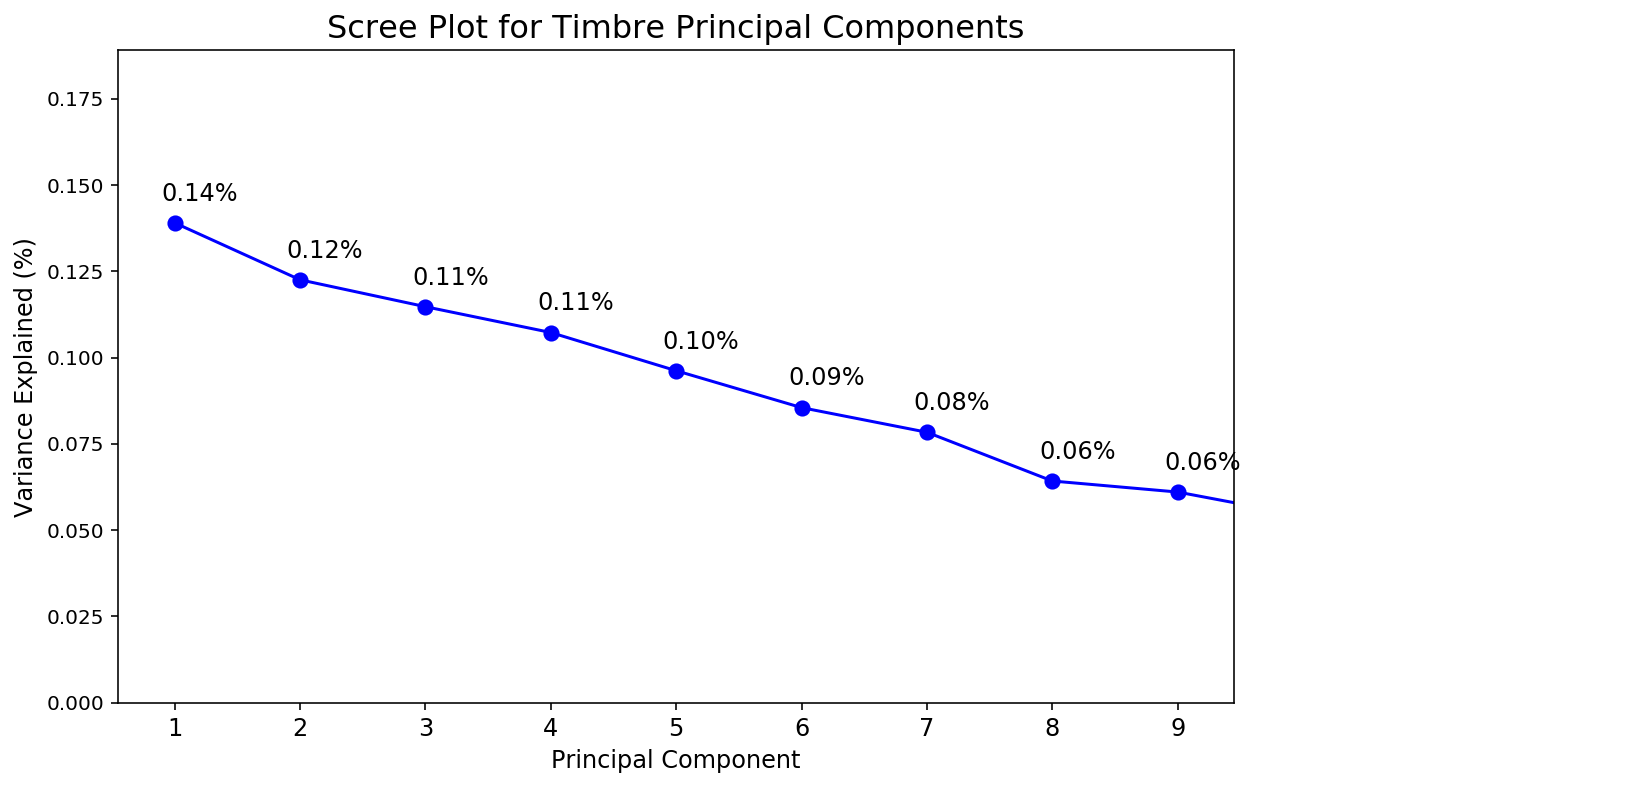

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))
scree_plot(ax, pca, title="Scree Plot for Timbre Principal Components")

In [62]:
y_train_long[248]

0

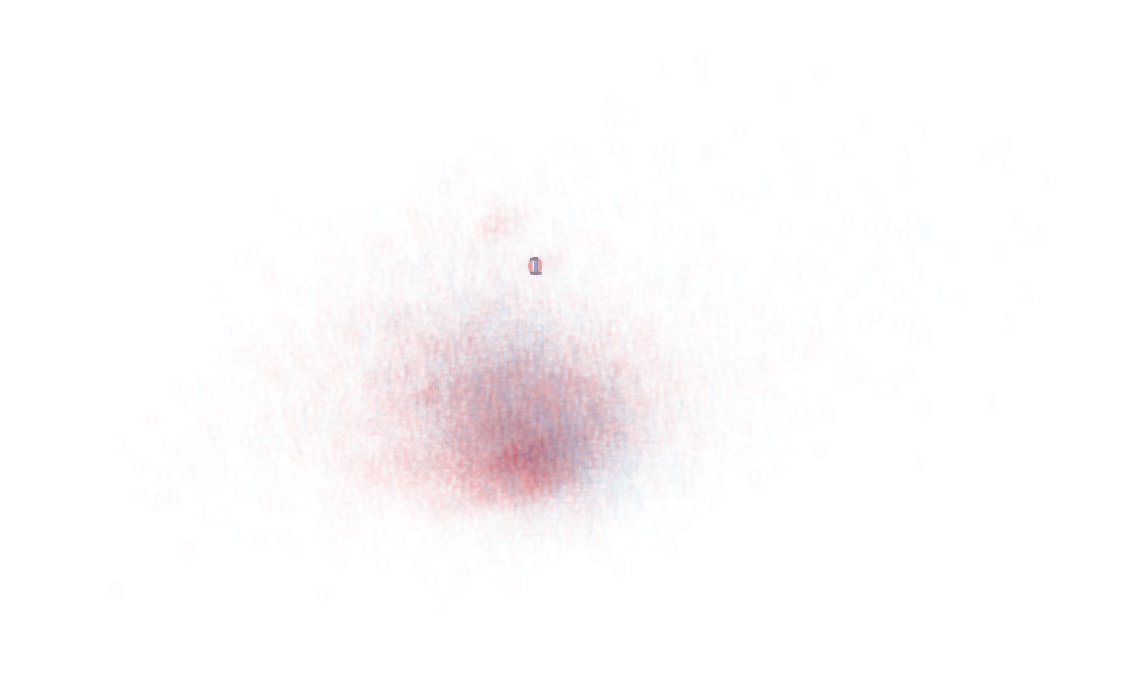

In [77]:
# pca = PCA(n_components=2)
# X_pca_long = pca.fit_transform(X_train_centered_long)


# fig, ax = plt.subplots(figsize=(10, 6))
# plot_mnist_embedding(ax, X_pca_long, y_train_long, alpha = 0.01)

In [63]:
pca = PCA(n_components=12)
X_test_centered_long = ss.transform(X_test_long)
X_pca_long = pca.fit_transform(X_train_centered_long)
X_test_pca_long = pca.transform(X_test_centered_long)


knn.fit(X_pca_long, y_train_long)
y_hat_long = knn.predict(X_test_pca_long)
acc = knn.score(X_test_pca_long, y_test_long)

print('Accuracy is: {}'.format(acc))

Accuracy is: 0.6753693853427896


But wait! This is the *segment* accuracy. Would it change if we took the mode prediction for a song?

    test train split songs
    *then* put in long form
    train pca
    take test data
    reshape into 80x12
    make predictions for each segment
    take the mode of the predictions
    calculate accuracy

In [64]:
# Extract Data
X = np.stack(data['timbre'].to_list())
y = data['target'].values

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 137, test_size = 0.3)

# Convert to Long Form
y_train_long = np.tile(y_train.reshape(-1,1), 80).flatten()
X_train_long = np.stack(X_train).reshape(-1,12)

X_test_long = np.stack(X_test).reshape(-1,12)

# Fit PCA
pca = PCA(n_components=12)
ss = StandardScaler()
X_train_centered_long = ss.fit_transform(X_train_long)
X_pca_train_long = pca.fit_transform(X_train_centered_long)

# Transform test data
X_test_centered_long = ss.transform(X_test_long)
X_test_pca_long = pca.transform(X_test_centered_long)

# Make a KNN model
knn.fit(X_pca_train_long, y_train_long)
y_hat_long = knn.predict(X_test_pca_long)

y_hat_long.shape

(67680,)

In [65]:
y_predict = scs.mode(y_hat_long.reshape(-1,80), axis = 1)[0].reshape(-1)

accuracy = (y_predict == y_test).sum()/(len(y_test))
accuracy

0.7494089834515366